In [ ]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [ ]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

In [ ]:
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
game.makeMove('d')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNet(nn.Module):
    def __init__(self, l1=64, l2=150, l3=100, l4=4):
        super().__init__()
        self.linear1 = nn.Linear(l1, l2)
        self.linear2 = nn.Linear(l2, l3)
        self.linear3 = nn.Linear(l3, l4)

    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        return out

In [ ]:
import numpy as np
import random
from matplotlib import pylab as plt

model = QNet(64, 150, 100, 4)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [ ]:
from tqdm import tqdm

gamma = 0.9
epsilon = 1.0

epochs = 1000
losses = []
for i in tqdm(range(epochs)):
    game = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    while (status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1, 64))
        maxQ = torch.max(newQ)
        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward

        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1:
            status = 0

    if epsilon > 0.1:
        epsilon -= (1 / epochs)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [00:45<00:00, 22.03it/s]


Text(0, 0.5, 'Loss')

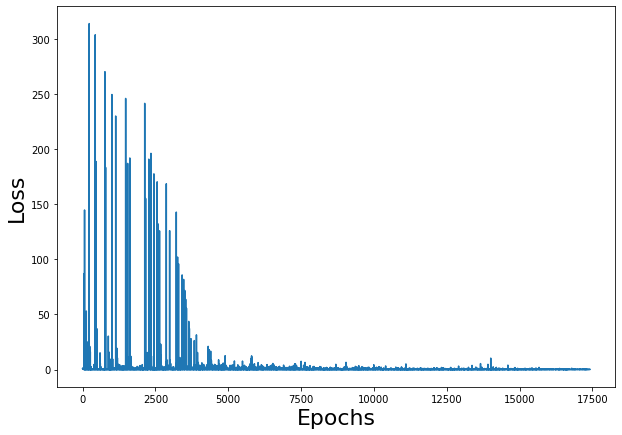

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 20):
            if display:
                print("Game lost; too many moves.")
            break

    win = True if status == 2 else False
    return win

In [ ]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='static', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 1000
Win percentage: 100.0%


In [ ]:
test_model(model, 'random')

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 [' ' ' ' 'P' ' ']
 [' ' ' ' '+' ' ']]
Move #: 0; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 [' ' 'P' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 ['P' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 2; Taking action: u
[[' ' ' ' ' ' ' ']
 ['P' ' ' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 3; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 4; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 5; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 6; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 7; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 8; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' 'W' '-']
 [

False

In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 187
Win percentage: 18.7%


In [ ]:
gamma = 0.9
epsilon = 1.0

epochs = 1000
losses = []
for i in tqdm(range(epochs)):
  game = Gridworld(size=4, mode='random')
  state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
  state1 = torch.from_numpy(state_).float()
  status = 1
  while (status == 1):
    qval = model(state1)
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0, 4)
    else:
      action_ = np.argmax(qval_)

    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1, 64))
    maxQ = torch.max(newQ)
    if reward == -1:
      Y = reward + (gamma * maxQ)
    else:
      Y = reward

    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_]
    loss = loss_fn(X, Y)
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    state1 = state2
    if reward != -1:
      status = 0

  if epsilon > 0.1:
    epsilon -= (1 / epochs)


100%|██████████| 1000/1000 [00:51<00:00, 19.34it/s]


In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 417
Win percentage: 41.699999999999996%


In [ ]:
test_model(model, 'random')

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[[' ' ' ' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[[' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[[' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: d
[[' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[[' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[[' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: d
[[' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: d
[[' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '+' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: d
[[' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [

False

In [ ]:
game = Gridworld(size=10, mode='random')
game.display()

array([[' ', ' ', ' ', ' ', ' ', ' ', 'P', ' ', ' ', ' '],
       [' ', ' ', ' ', 'W', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', '-', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', '+', ' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
game.board.render_np().shape

(4, 10, 10)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNet(nn.Module):
    def __init__(self, l1=400, l2=100, l3=4):
        super().__init__()
        self.linear1 = nn.Linear(l1, l2)
        self.linear2 = nn.Linear(l2, l3)

    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = self.linear2(out)
        return out




In [ ]:
import numpy as np
import random
from matplotlib import pylab as plt

model = QNet(400,100, 4)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [ ]:
np.random.rand(1, 64)

array([[0.13642862, 0.91806042, 0.78569145, 0.58493707, 0.15669141,
        0.64000949, 0.99964523, 0.98571678, 0.50522813, 0.04703571,
        0.20412792, 0.22049026, 0.96571831, 0.29183544, 0.37247016,
        0.30581844, 0.2457684 , 0.37389139, 0.58651343, 0.76450131,
        0.43314569, 0.62592742, 0.43911   , 0.4579953 , 0.46368097,
        0.68055385, 0.98240243, 0.85130061, 0.216374  , 0.88993255,
        0.39028593, 0.79112576, 0.3939879 , 0.90822894, 0.86214811,
        0.0059456 , 0.82679594, 0.30881552, 0.79781433, 0.99873851,
        0.10034401, 0.42692553, 0.6063694 , 0.99941174, 0.98789153,
        0.64121272, 0.67099031, 0.61557662, 0.15808834, 0.64874267,
        0.818576  , 0.46528571, 0.70210414, 0.23438908, 0.09226142,
        0.42690953, 0.1771078 , 0.31516671, 0.55187202, 0.42957323,
        0.04961592, 0.33334721, 0.20683159, 0.00596443]])

In [ ]:
from tqdm import tqdm

gamma = 0.9
epsilon = 1.0

epochs = 1000
losses = []
for i in tqdm(range(epochs)):
    game = Gridworld(size=10, mode='static')
    state_ = game.board.render_np().reshape(1, 400) + np.random.rand(1, 400) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    while (status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 400) + np.random.rand(1, 400) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1, 400))
        maxQ = torch.max(newQ)
        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward

        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1:
            status = 0

    if epsilon > 0.1:
        epsilon -= (1 / epochs)

100%|██████████| 1000/1000 [02:17<00:00,  7.25it/s]


Text(0, 0.5, 'Loss')

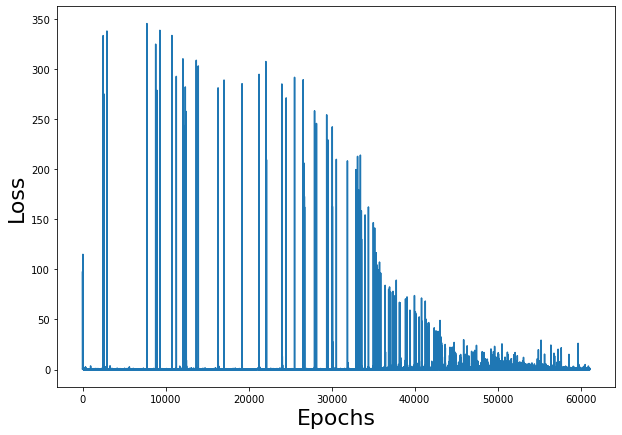

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
test_game = Gridworld(size=10,mode='random')

In [ ]:
test_game.board.render_np().shape

(4, 10, 10)

In [ ]:
def test_model(model, mode='random', display=True):
    i = 0
    test_game = Gridworld(size=10,mode=mode)
    state_ = test_game.board.render_np().reshape(1,400) + np.random.rand(1,400)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,400) + np.random.rand(1,400)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 20):
            if display:
                print("Game lost; too many moves.")
            break

    win = True if status == 2 else False
    return win

In [ ]:
test_model(model, 'random')

Initial State:
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' '-' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' '+' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' '-' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' '+' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' 

False

In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 95
Win percentage: 9.5%
